In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 150
import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso

## ALL

In [81]:
data = pd.read_csv('data/tracks_no_may.csv', encoding='utf-8', index_col=False)

In [ ]:
one_hot = pd.get_dummies(data['genre'], prefix='genre').iloc[:, :-1]
df = pd.concat([data.iloc[:, 4:-1], one_hot[:]], axis=1)
formula = 'popularity ~ '
for i, c in enumerate(df.columns[1:]):
    if c == 'release_date':
        continue
    if i != 0:
        formula += ' + '
    formula += f'Q("{c}")'
model = smf.ols(formula, data=df).fit()
model.summary()

In [7]:
data.head()

,Unnamed: 0,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,...,duration_ms,key,loadness,mode,tempo,valence,available_market,release_date,explicit,idx
0,0,5OpjJ9qy54D3PzQJ1s4Q9X,TESTIFY,acoustic,https://open.spotify.com/track/5OpjJ9qy54D3PzQ...,59.0,0.471,0.495,0.710,0.000000,...,243800.0,0.0,-3.941,1.0,90.024,0.319,79.0,2016-07-15,0.0,0
1,1,6ZgaHk6yrHBbHrbTmKl2pZ,Learned A Lot,acoustic,https://open.spotify.com/track/6ZgaHk6yrHBbHrb...,39.0,0.850,0.556,0.285,0.068000,...,270786.0,0.0,-9.884,1.0,128.167,0.322,78.0,2011,0.0,1
2,2,4wQKyYfNDY7E8ybcp0hF61,Jupiter's Call,acoustic,https://open.spotify.com/track/4wQKyYfNDY7E8yb...,35.0,0.879,0.694,0.354,0.000083,...,180952.0,2.0,-12.275,1.0,130.346,0.652,79.0,2018-06-01,0.0,2
3,3,3JndPOkXLuhupgWnRrPSua,Rain,acoustic,https://open.spotify.com/track/3JndPOkXLuhupgW...,36.0,0.654,0.497,0.372,0.000000,...,248293.0,5.0,-8.094,1.0,94.604,0.290,56.0,2002-04-09,0.0,3
4,4,3tjQYh1H3c17IQMdd8AIBb,The Shining Barrier,acoustic,https://open.spotify.com/track/3tjQYh1H3c17IQM...,40.0,0.794,0.373,0.160,0.764000,...,251075.0,10.0,-21.342,1.0,112.578,0.144,79.0,2014-09-15,0.0,4


In [379]:
gen = ['j-pop', 'k-pop', 'hip-hop', 'country', 'dance', 'jazz', 'pop', 'blues']
datas = {g:data[data["genre"] == g] for g in gen}

In [380]:
class Track():
    def __init__(self, data, gen=None):
        if gen is not None:
            self.data = data[data["genre"] == gen]
        else:
            self.data = data
        self.result = None
        self.adj_R_squared = 0
    def get_result(self, formula):
        one_hot = pd.get_dummies(self.data['key'], prefix = 'key_')
        df = pd.concat([self.data,one_hot],axis=1)
        remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'key_12.0', 'loadness']
        self.result = smf.ols(formula, data=df).fit()
        self.adj_R_squared = self.result.rsquared_adj
        print(self.result.rsquared_adj)
    def plot(self):
        y = 'popularity'
        remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name']
        xs = [c for c in self.data.columns if c not in remove and c != 'Unnamed: 0' and c != y]
        plt.figure(figsize=(12, 25))
        for i, x in enumerate(xs):
            plt.subplot((len(xs)+1)//2, 2, i+1)
            plt.scatter(self.data[x], self.data[y], c=self.data['key'])
            plt.xlabel(x)
            plt.ylabel(y)
        plt.show()
    def check_norm(self):
        res = self.result.resid_pearson
        plt.hist(res, bins = 'auto')
        plt.show()
        
        sm.qqplot(res, stats.norm, fit=True, line='45')
        plt.show()
        stat, p = stats.shapiro(res)
        print(f'Shapiro: statistics={stat:.3f}, p={p:.3f}')
    def check_heter(self):
        res = self.result
        _, stat, names = sso.summary_table(res, alpha=0.05)
        plt.scatter(stat[:,2], res.resid)
        plt.axhline(y=0, color = 'red')
        plt.xlabel('prediction')
        plt.ylabel('residuals')
    def find_outliers_influ_obs(self):
        res = self.result
        _, stat, names = sso.summary_table(res, alpha=0.05)
        plt.scatter(stat[:,2], stat[:,10])
        plt.axhline(y=2, color='red')
        plt.axhline(y=-2, color='red')
        plt.title('Outliers')
        plt.ylabel('studentized residuals')
        plt.xlabel('prediction')
        plt.show()
        plt.scatter(stat[:,2], stat[:,11])
        plt.title('Influential Observations')
        plt.ylabel("Cook's distance")
        plt.xlabel('prediction')
        plt.show()
    def print_outliers(self):
        res = self.result
        _, stat, names = sso.summary_table(res, alpha=0.05)
        stat[np.isnan(stat)] = 0
        display(self.data[abs(stat[:, 10]) > 2])
    def print_influential_observations(self):
        res = self.result
        _, stat, names = sso.summary_table(res, alpha=0.05)
        stat[np.isnan(stat)] = 0
        display(self.data[stat[:, 11] > 1])
    def correlations(self):
        corr = self.data.corr()
        _ = sns.heatmap(abs(corr), annot=True, annot_kws={"size": 5})
        plt.show()

In [381]:
tracks = {g:Track(data, g) for g in gen}

In [382]:
one_hot = pd.get_dummies(data['key'], prefix = 'key_')
df = pd.concat([data,one_hot],axis=1)
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'key_12.0', 'loadness']
formula = 'popularity ~ '
first = True
for i, c in enumerate(df.columns[1:]):
    if c in remove:
        continue
    if not first:
        formula += ' + '
    else:
        first = False
    formula += f'Q("{c}")'
tracks['hip-hop'].get_result(formula)

0.18981763781211758


In [383]:
tracks['jazz'].get_result(formula)

0.17716642290461004


In [384]:
tracks['blues'].get_result(formula)

0.06246925468958009


In [391]:
data = data.iloc[[g in gen for g in data['genre']],:]
one_hot = pd.get_dummies(data['genre'], prefix='genre_').iloc[:, :-1]
df = pd.concat([data.iloc[:, 4:-1], one_hot[:]], axis=1)
one_hot = pd.get_dummies(df['key'], prefix = 'key_')
df = pd.concat([df,one_hot],axis=1)
df.head()

,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,duration_ms,key,...,key__2.0,key__3.0,key__4.0,key__5.0,key__6.0,key__7.0,key__8.0,key__9.0,key__10.0,key__11.0
757,https://open.spotify.com/track/36KStm44i8gAqnQ...,52.0,0.88900,0.701,0.296,0.000002,0.2790,0.2000,199226.0,4.0,...,0,0,1,0,0,0,0,0,0,0
758,https://open.spotify.com/track/7cy1bEJV6FCtDaY...,68.0,0.31900,0.623,0.910,0.000448,0.0810,0.0384,195306.0,9.0,...,0,0,0,0,0,0,0,1,0,0
759,https://open.spotify.com/track/0l4mKN097GpgeBG...,44.0,0.02570,0.459,0.494,0.000000,0.5560,0.0397,225860.0,11.0,...,0,0,0,0,0,0,0,0,0,1
760,https://open.spotify.com/track/3VyJPsb2ucaaVpt...,51.0,0.60800,0.559,0.446,0.000131,0.0902,0.0349,245452.0,10.0,...,0,0,0,0,0,0,0,0,1,0
761,https://open.spotify.com/track/5aYVqxyetmT5OYm...,56.0,0.00608,0.449,0.642,0.007070,0.1750,0.0487,494533.0,2.0,...,1,0,0,0,0,0,0,0,0,0


In [392]:
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'key_0.0', 'genre_pop', 'loadness']
formula = 'popularity ~ '
first = True
for i, c in enumerate(df.columns[1:]):
    if c in remove:
        continue
    if not first:
        formula += ' + '
    else:
        first = False
    formula += f'Q("{c}")'
formula

'popularity ~ Q("acousticness") + Q("danceability") + Q("energy") + Q("instrumentalness") + Q("liveness") + Q("speechiness") + Q("duration_ms") + Q("mode") + Q("tempo") + Q("valence") + Q("available_market") + Q("explicit") + Q("genre__blues") + Q("genre__country") + Q("genre__dance") + Q("genre__hip-hop") + Q("genre__j-pop") + Q("genre__jazz") + Q("genre__k-pop") + Q("key__0.0") + Q("key__1.0") + Q("key__2.0") + Q("key__3.0") + Q("key__4.0") + Q("key__5.0") + Q("key__6.0") + Q("key__7.0") + Q("key__8.0") + Q("key__9.0") + Q("key__10.0") + Q("key__11.0")'

In [393]:
one_hot = pd.get_dummies(df['key'], prefix = 'key_')
df_result = smf.ols(formula, data=df).fit()
df_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     53.36
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          3.40e-159
Time:                        19:32:23   Log-Likelihood:                -2353.4
No. Observations:                 733   AIC:                             4769.
Df Residuals:                     702   BIC:                             4911.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                63.7311      2.334     27.303      0.000      59.148      68.314
Q("acousticness")        -0.5936      1.223     -0.485      0.627      -2.994       1.807
Q("danceability")         2.5973      1.988      1.306      0.192      -1.306       6.500
Q("energy")               0.6037      1.688      0.358      0.721      -2.709       3.917
Q("instrumentalness")    -2.1661      1.403     -1.544      0.123      -4.921       0.589
Q("liveness")             1.7026      1.697      1.003      0.316      -1.629       5.034
Q("speechiness")         -4.5969      2.801     -1.641      0.101     -10.096       0.902
Q("duration_ms")      -6.087e-07   3.97e-06     -0.153      0.878   -8.41e-06    7.19e-06
Q("mode")                 0.0489      0.506      0.097      0.923      -0.944       1.042
Q("tempo")               -0.0092      0.008     -1.136      0.256      -0.025       0.007
Q("valence")              0.0170      1.254      0.014      0.989      -2.444       2.478
Q("available_market")     0.0666      0.011      6.199      0.000       0.045       0.088
Q("explicit")            -0.5268      0.869     -0.606      0.545      -2.234       1.180
Q("genre__blues")       -22.3393      1.002    -22.299      0.000     -24.306     -20.372
Q("genre__country")     -12.5001      0.978    -12.782      0.000     -14.420     -10.580
Q("genre__dance")        -4.7670      0.946     -5.039      0.000      -6.624      -2.910
Q("genre__hip-hop")      -5.2139      1.056     -4.937      0.000      -7.288      -3.140
Q("genre__j-pop")       -24.9095      0.976    -25.529      0.000     -26.825     -22.994
Q("genre__jazz")        -22.1251      1.105    -20.015      0.000     -24.295     -19.955
Q("genre__k-pop")       -17.1460      0.989    -17.336      0.000     -19.088     -15.204
Q("key__0.0")             5.3574      0.704      7.615      0.000       3.976       6.739
Q("key__1.0")             5.4052      0.672      8.044      0.000       4.086       6.724
Q("key__2.0")             5.8293      0.757      7.702      0.000       4.343       7.315
Q("key__3.0")             5.1820      1.200      4.318      0.000       2.826       7.538
Q("key__4.0")             5.2242      0.874      5.977      0.000       3.508       6.940
Q("key__5.0")             4.3628      0.769      5.671      0.000       2.852       5.873
Q("key__6.0")             3.6240      0.969      3.739      0.000       1.721       5.527
Q("key__7.0")             6.3471      0.714      8.886      0.000       4.945       7.750
Q("key__8.0")             6.2652      0.867      7.223      0.000       4.562       7.968
Q("key__9.0")             6.0471      0.730      8.287      0.000       4.614       7.480
Q("key__10.0")            5.5162      0.904      6.103      0.000       3.741       7.291
Q("key__11.0")         

In [336]:
tracks_all.result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     145.2
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:01:29   Log-Likelihood:                -4051.9
No. Observations:                1201   AIC:                             8178.
Df Residuals:                    1164   BIC:                             8366.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                56.9870      2.141     26.618      0.000      52.787      61.187
Q("acousticness")        -0.3506      1.215     -0.288      0.773      -2.735       2.034
Q("danceability")         1.0045      1.863      0.539      0.590      -2.651       4.660
Q("energy")               0.8570      1.614      0.531      0.595      -2.309       4.023
Q("instrumentalness")    -0.6631      1.027     -0.646      0.519      -2.678       1.352
Q("liveness")             0.2377      1.459      0.163      0.871      -2.626       3.101
Q("speechiness")         -5.3031      2.708     -1.959      0.050     -10.616       0.009
Q("duration_ms")       1.799e-06   3.34e-06      0.539      0.590   -4.75e-06    8.35e-06
Q("mode")                 0.0899      0.467      0.193      0.847      -0.826       1.006
Q("tempo")               -0.0006      0.007     -0.084      0.933      -0.015       0.014
Q("valence")             -0.0064      1.176     -0.005      0.996      -2.314       2.301
Q("available_market")     0.0846      0.009      9.016      0.000       0.066       0.103
Q("explicit")            -0.9223      0.816     -1.130      0.259      -2.524       0.679
Q("genre_blues")        -16.8413      1.074    -15.687      0.000     -18.948     -14.735
Q("genre_classical")     -5.0475      3.811     -1.324      0.186     -12.525       2.430
Q("genre_country")       -6.9186      1.054     -6.563      0.000      -8.987      -4.850
Q("genre_dance")          1.0381      1.097      0.946      0.344      -1.114       3.190
Q("genre_disney")       -41.6207      1.252    -33.245      0.000     -44.077     -39.164
Q("genre_hip-hop")        0.9748      1.321      0.738      0.461      -1.617       3.567
Q("genre_j-idol")       -38.1588      1.092    -34.941      0.000     -40.302     -36.016
Q("genre_j-pop")        -19.2600      1.069    -18.014      0.000     -21.358     -17.162
Q("genre_jazz")         -17.1881      1.166    -14.738      0.000     -19.476     -14.900
Q("genre_k-pop")        -11.5890      1.102    -10.520      0.000     -13.750      -9.428
Q("genre_metal")         -8.0261      1.134     -7.077      0.000     -10.251      -5.801
Q("genre_opera")        -30.9344      1.354    -22.840      0.000     -33.592     -28.277
Q("genre_pop")            5.7727      1.118      5.164      0.000       3.580       7.966
Q("key__0.0")             5.4843      0.650      8.441      0.000       4.210       6.759
Q("key__1.0")             4.5756      0.649      7.051      0.000       3.302       5.849
Q("key__2.0")             4.6907      0.661      7.095      0.000       3.394       5.988
Q("key__3.0")             5.4746      1.029      5.322      0.000       3.456       7.493
Q("key__4.0")             3.8989      0.745      5.236      0.000       2.438       5.360
Q("key__5.0")          

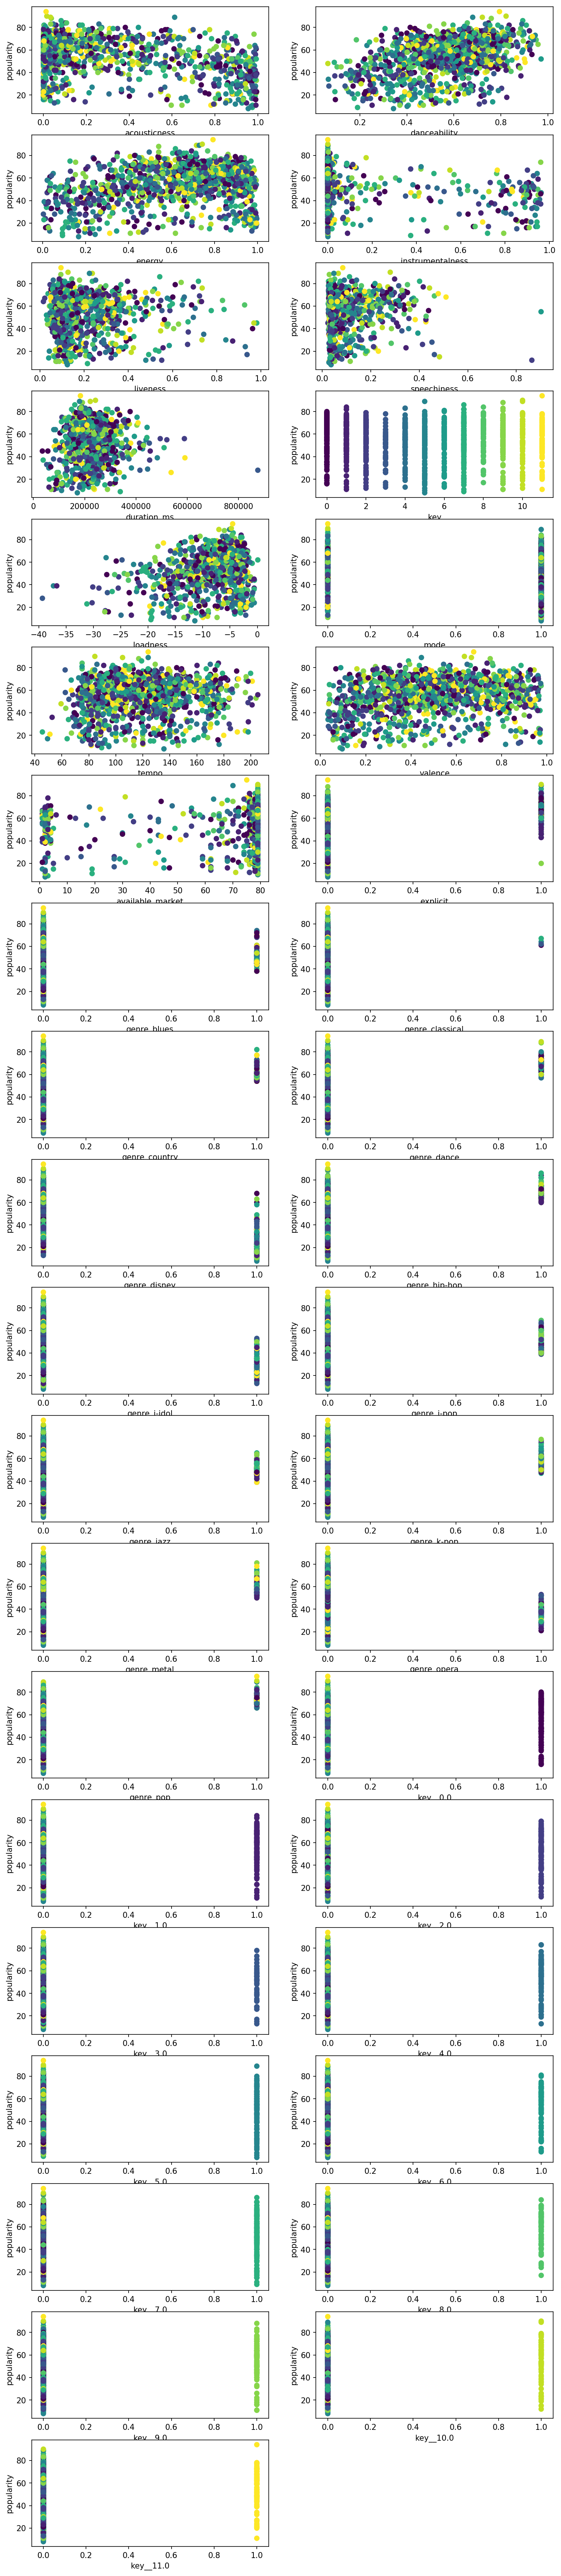

In [337]:
tracks_all.plot()

In [339]:
tracks_all[['loadness','acoustiness','energy']].correlations()

TypeError: 'Track' object is not subscriptable

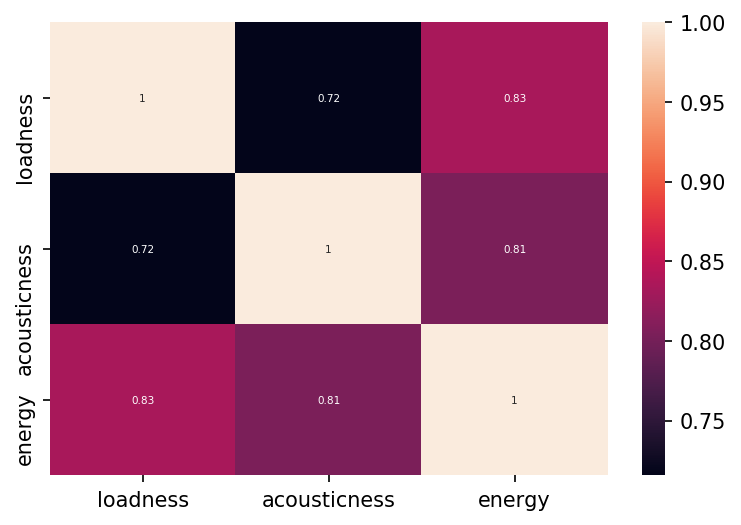

In [343]:
corr = tracks_all.data[['loadness','acousticness','energy']].corr()
_ = sns.heatmap(np.abs(corr), annot=True, annot_kws={"size": 5})
plt.show()